In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import sys
import cv2 as cv
from tqdm import tqdm

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
combine_fold = 'C:/Users/oryan/Documents/mergers-in-cosmos/cats-to-combine'
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-data'
fig_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures'
cos_dat_fold = 'E:/cosmos-data'

### Importing my Data

In [3]:
df_cat = pd.read_csv(f'{combine_fold}/dor-all-restaged-full.csv', index_col = 0)

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df_cat.head()

,ORyanID_23,ID,category,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,4000705532455,816891,stage4,150.679846,2.196543,9200.399414,21737.232422,0.000052,0.000059,-0.000010,...,-8.931825,-8.911355,-8.899668,-8.883307,-8.872990,0.529107,0.560142,0.599624,0.630920,0.652330
1,4000705533383,860686,stage3,150.644522,2.237226,10047.978516,22713.351562,0.000051,0.000046,0.000002,...,-9.314209,-9.106611,-8.941274,-8.713107,-8.541205,0.341270,0.545498,0.732327,0.906665,1.020098
2,4000705539941,1301188,stage2,149.702462,2.654895,32637.949219,32737.013672,0.000064,0.000104,-0.000003,...,-9.794128,-9.784252,-9.766013,-9.743796,-9.727879,0.018737,0.018737,0.018737,0.018737,0.018737
3,4000705540034,1304538,stage3,149.726828,2.658172,32053.712891,32815.468750,0.000071,0.000086,-0.000006,...,-9.480532,-9.443615,-9.402433,-9.352081,-9.325659,0.302629,0.376027,0.440394,0.508153,0.567727
4,4000705540064,1310001,stage3,149.701230,2.660343,32667.441406,32867.789062,0.000026,0.000020,-0.000010,...,-9.882174,-9.855921,-9.816085,-9.697225,-9.573506,0.455258,0.482555,0.522239,0.600383,0.660279


In [6]:
df_red_tmp = df_cat.query('ez_sfr < 10')
df_red = df_red_tmp.query('lp_mass_best >= 9.6')

In [61]:
len(df_red)

2800

In [17]:
df_IDS = (
    df_red[['ID', 'ID_COSMOS2015']]
)

### Importing Dervish Data

In [9]:
environ_data = pd.read_csv(f'{cos_dat_fold}/darvish17-environ.csv')

In [10]:
len(environ_data)

45421

In [26]:
environ_data_red = environ_data.query('flag == 0').rename(columns = {'ID' : 'ID_COSMOS2015'})

In [27]:
len(environ_data_red)

38865

Match on ID_COSMOS2015

### Matching Catalogues

In [28]:
df_environ_match = (
    df_IDS.merge(environ_data_red, on = 'ID_COSMOS2015', how = 'left')
)

In [29]:
matched_red = df_environ_match[['ID', 'density', 'environment']].dropna()
matched_red

,ID,density,environment
0,860686,4.23,field
1,1304538,0.96,field
2,1310001,3.08,field
3,1308927,2.78,field
4,1311422,2.26,filament
...,...,...,...
2759,1407959,29.56,cluster
2760,1408623,6.72,filament
2761,1409169,1.12,field
2762,1410323,1.47,filament


In [30]:
matched_red.density.min()

0.22

In [31]:
matched_red.density.max()

89.07

In [32]:
log_matched_red = (
    matched_red
    .assign(log_density = matched_red.density.apply(lambda x: np.log10(x)))
)

### Diagnostics of Environment Measure

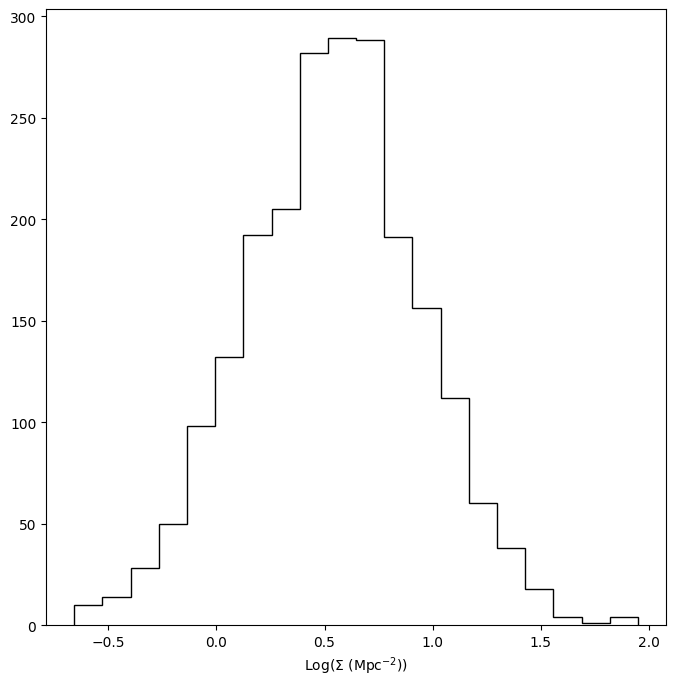

In [33]:
plt.figure(figsize = (8,8))
plt.hist(np.array(log_matched_red.log_density), bins = 20, histtype='step', color='black')
plt.xlabel('Log($\Sigma$ (Mpc$^{-2}$))')
plt.show()

In [34]:
df_cat = df_red[['ID', 'category', 'lp_mass_best', 'ez_sfr']]

In [35]:
df_environ_merg = log_matched_red.merge(df_cat, on = 'ID', how = 'left')
df_environ_merg

,ID,density,environment,log_density,category,lp_mass_best,ez_sfr
0,860686,4.23,field,0.626340,stage3,10.44862,1.609304
1,1304538,0.96,field,-0.017729,stage3,9.96798,1.101499
2,1310001,3.08,field,0.488551,stage3,10.41827,1.083541
3,1308927,2.78,field,0.444045,stage3,10.03523,1.198906
4,1311422,2.26,filament,0.354108,stage3,9.64588,0.392114
...,...,...,...,...,...,...,...
2167,1407959,29.56,cluster,1.470704,stage1,11.39123,0.488474
2168,1408623,6.72,filament,0.827369,stage1,9.82889,0.859957
2169,1409169,1.12,field,0.049218,stage4,10.24347,1.675080
2170,1410323,1.47,filament,0.167317,stage1,10.79690,1.226886


In [36]:
df_environ_merg.category.value_counts()

stage3    803
stage2    495
stage1    467
stage4    407
Name: category, dtype: int64

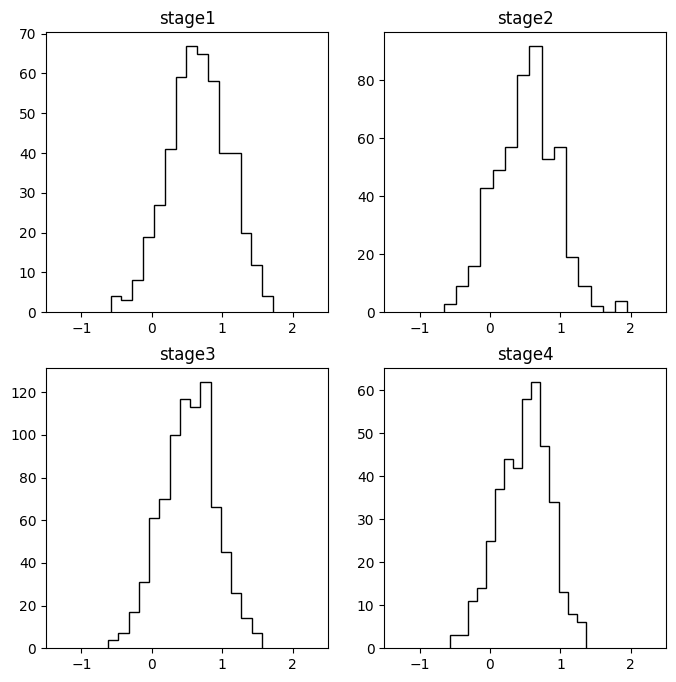

In [38]:
counter = 1
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
for i in range(2):
    for j in range(2):
        stage = f'stage{counter}'
        densities = np.array(df_environ_merg.query('category == @stage').log_density)
        
        ax[i,j].hist(densities, bins = 15, histtype='step', color='black')
        ax[i,j].set_title(stage)
        ax[i,j].set_xlim([-1.5, 2.5])
        
        counter += 1

### Controlling for Environment and Stage

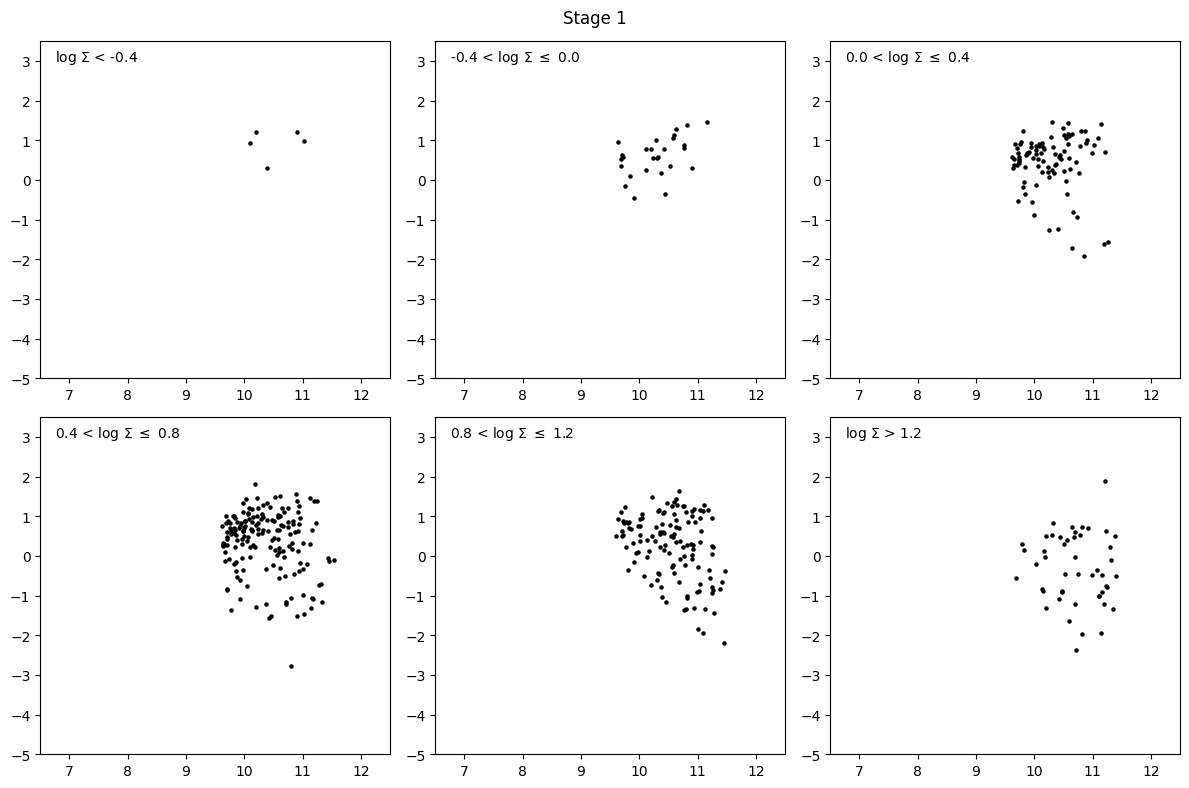

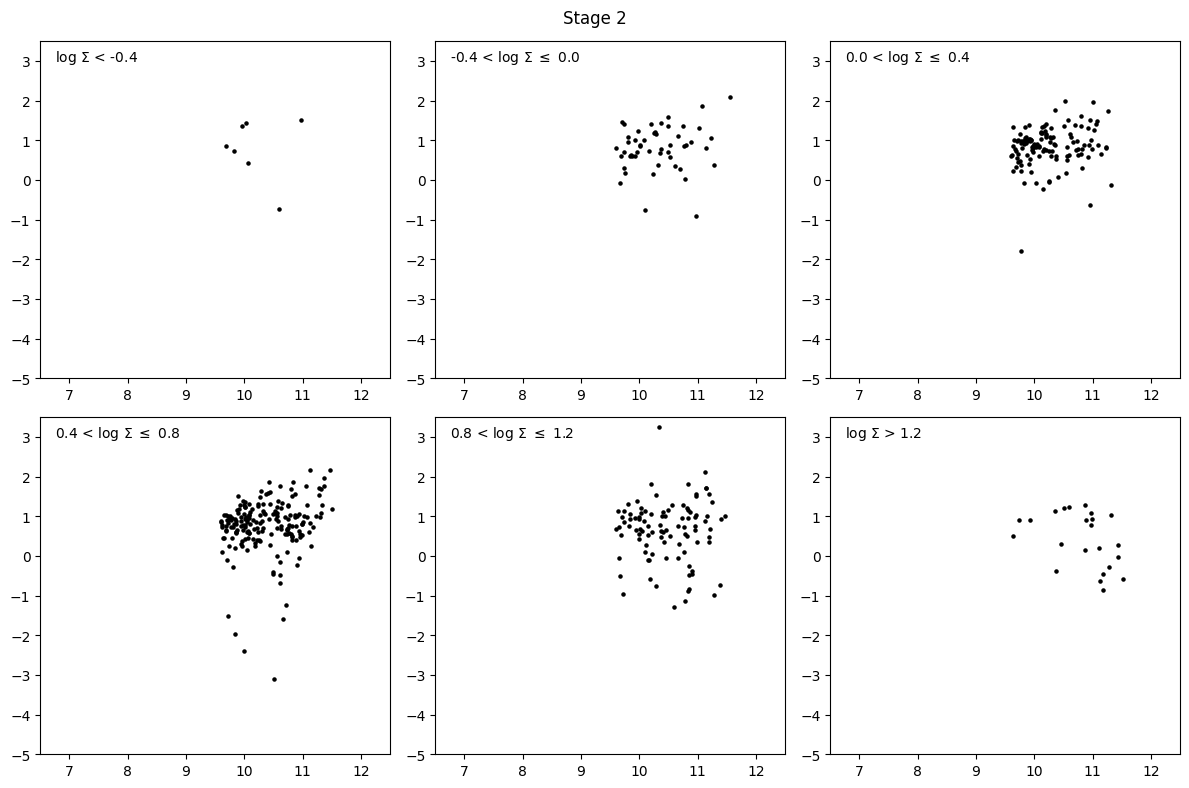

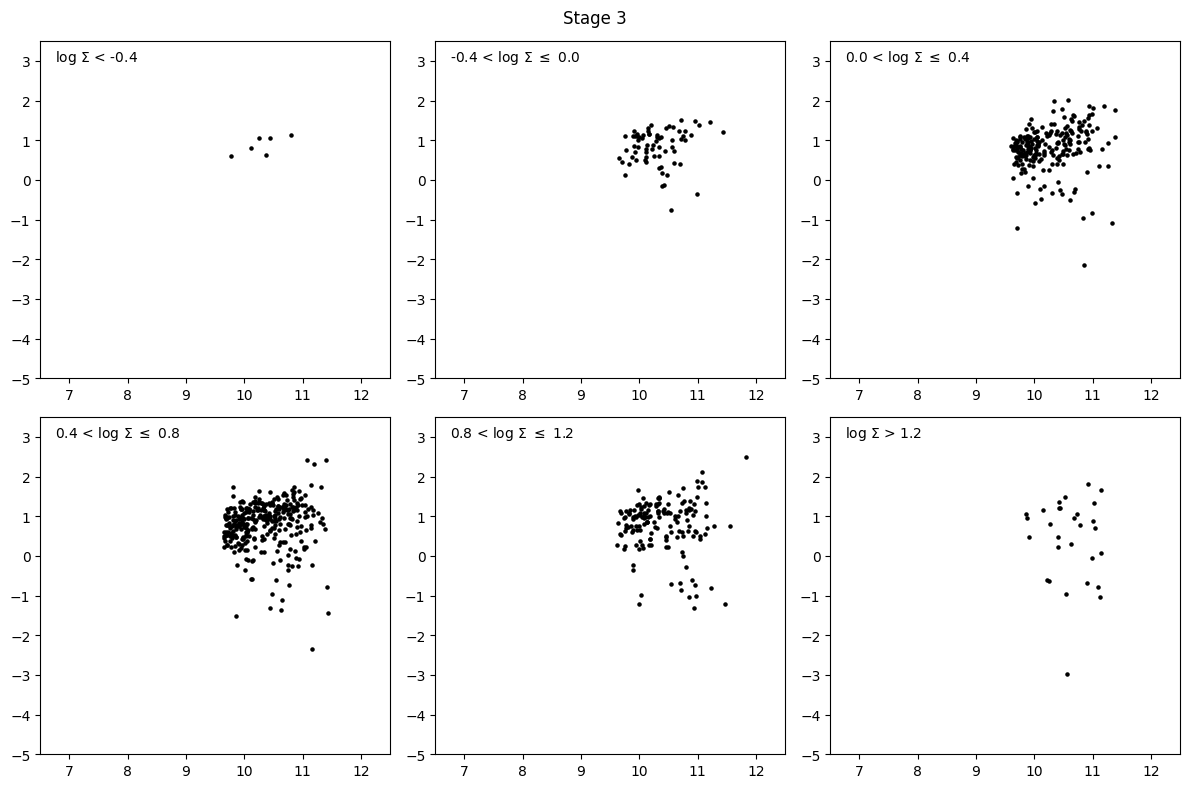

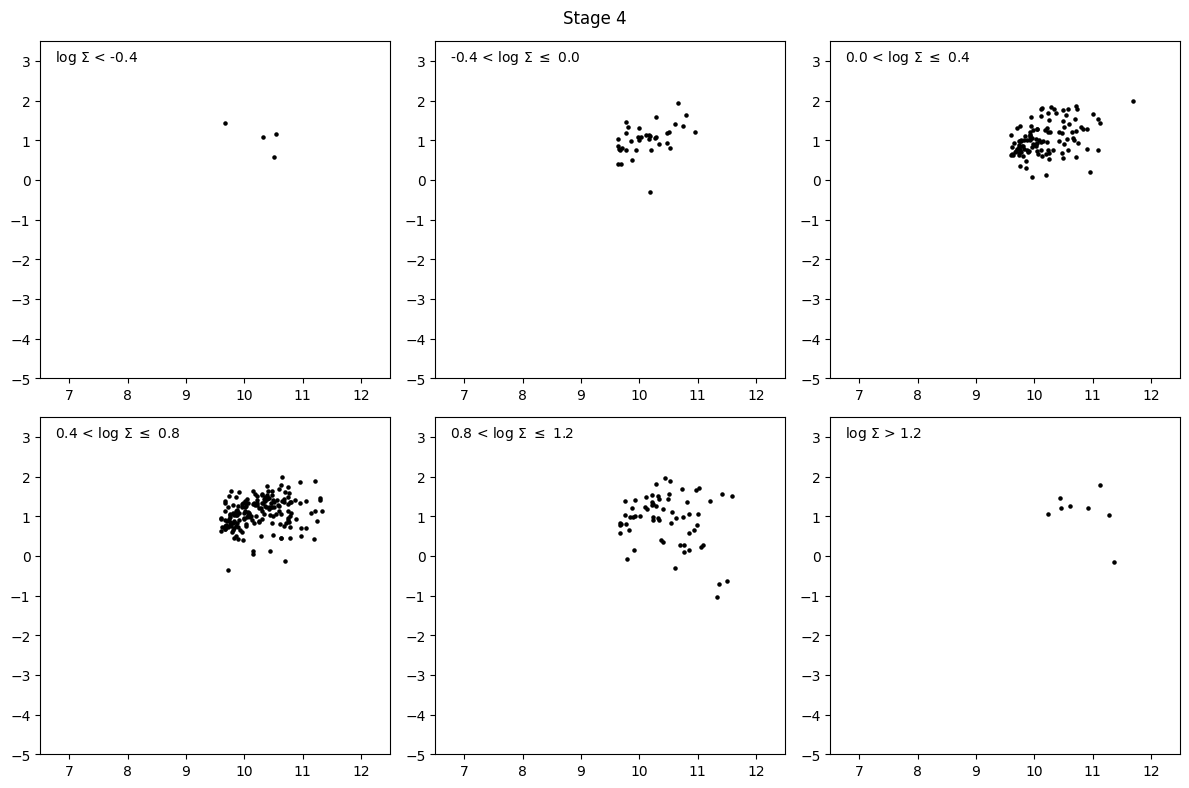

In [39]:
counter_stage = 1
cuts = [-0.4, 0.0, 0.4, 0.8, 1.2]
for i in range(4):
    fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (12,8))
    stage = f'stage{counter_stage}'
    df_stage = df_environ_merg.query('category == @stage')
    counter_env = 0
    for j in range(2):
        for k in range(3):
            if counter_env == 0:
                cut = cuts[counter_env]
                df_env = df_stage.query('log_density < @cut')
                ax[j,k].scatter(np.array(df_env.lp_mass_best), np.array(df_env.ez_sfr), s = 5, color = 'black')
                ax[j,k].text(6.75, 3, f'log $\Sigma$ < {cut}')
                ax[j,k].set_xlim([6.5,12.5])
                ax[j,k].set_ylim([-5,3.5])
                counter_env += 1
            elif counter_env < 5:
                cut_1 = cuts[counter_env - 1]
                cut_2 = cuts[counter_env]
                df_env = df_stage.query('log_density > @cut_1 and log_density <= @cut_2')
                ax[j,k].scatter(np.array(df_env.lp_mass_best), np.array(df_env.ez_sfr), s = 5, color = 'black')
                ax[j,k].text(6.75, 3, f'{cut_1} < log $\Sigma$ $\leq$ {cut_2}')
                ax[j,k].set_xlim([6.5,12.5])
                ax[j,k].set_ylim([-5,3.5])
                counter_env += 1
            elif counter_env == 5:
                cut = cuts[counter_env-1]
                df_env = df_stage.query('log_density > @cut')
                ax[j,k].scatter(np.array(df_env.lp_mass_best), np.array(df_env.ez_sfr), s = 5, color = 'black')
                ax[j,k].text(6.75, 3, f'log $\Sigma$ > {cut}')
                ax[j,k].set_xlim([6.5,12.5])
                ax[j,k].set_ylim([-5,3.5])
                counter_env += 1
            
    fig.suptitle(f'Stage {counter_stage}')
    fig.tight_layout()
                
                
    counter_stage += 1

### Trying to do in One

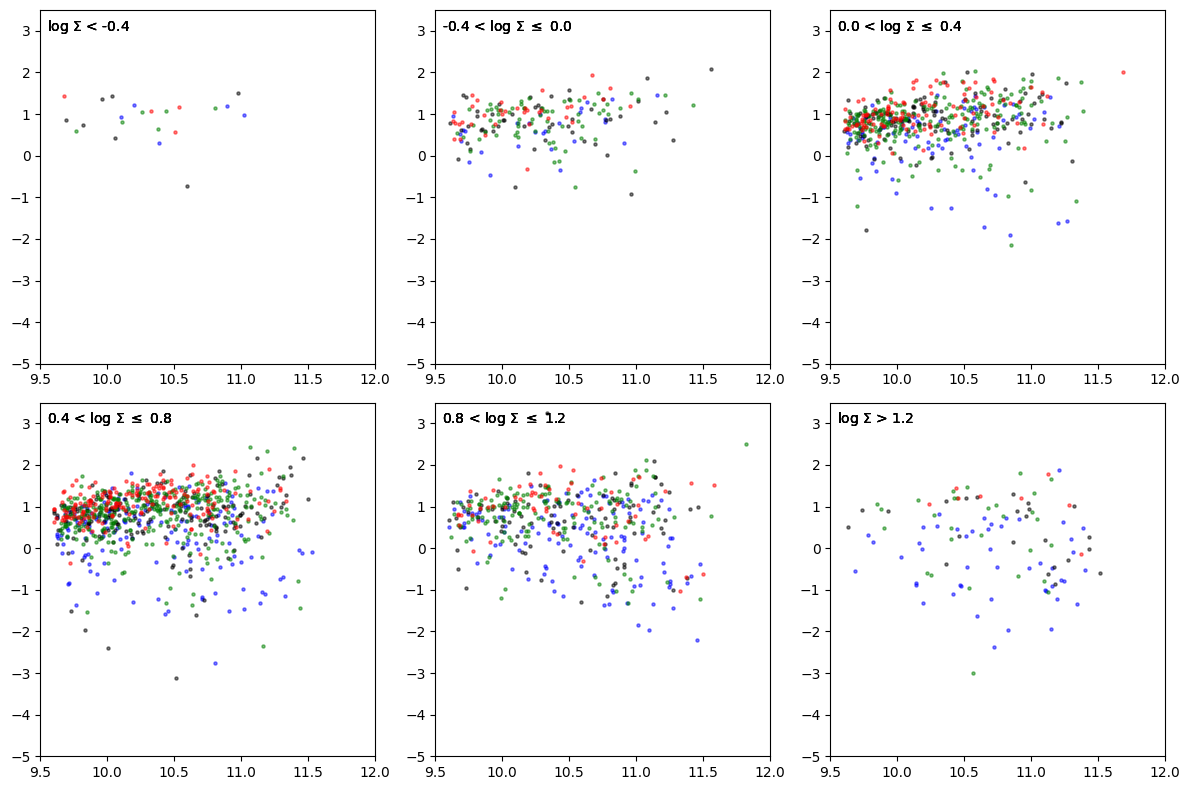

In [53]:
counter_env = 0
cuts = [-0.4, 0.0, 0.4, 0.8, 1.2]
colours = ['blue', 'black', 'green', 'red']
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (12,8))
for j in range(2):
    for k in range(3):
        counter_stage = 0
        for i in range(4):
            stage = f'stage{i+1}'
            df_stage = df_environ_merg.query('category == @stage')

            if counter_env == 0:
                cut = cuts[counter_env]
                df_env = df_stage.query('log_density < @cut')
                ax[j,k].scatter(np.array(df_env.lp_mass_best), np.array(df_env.ez_sfr), s = 5, color = colours[i], alpha=0.5)
                ax[j,k].text(9.55, 3, f'log $\Sigma$ < {cut}')
                ax[j,k].set_xlim([9.5,12.])
                ax[j,k].set_ylim([-5,3.5])
            elif counter_env < 5:
                cut_1 = cuts[counter_env - 1]
                cut_2 = cuts[counter_env]
                df_env = df_stage.query('log_density > @cut_1 and log_density <= @cut_2')
                ax[j,k].scatter(np.array(df_env.lp_mass_best), np.array(df_env.ez_sfr), s = 5, color = colours[i],alpha=0.5)
                ax[j,k].text(9.55, 3, f'{cut_1} < log $\Sigma$ $\leq$ {cut_2}')
                ax[j,k].set_xlim([9.5,12.])
                ax[j,k].set_ylim([-5,3.5])
            elif counter_env == 5:
                cut = cuts[counter_env-1]
                df_env = df_stage.query('log_density > @cut')
                ax[j,k].scatter(np.array(df_env.lp_mass_best), np.array(df_env.ez_sfr), s = 5, color = colours[i],alpha=0.5)
                ax[j,k].text(9.55, 3, f'log $\Sigma$ > {cut}')
                ax[j,k].set_xlim([9.5,12.])
                ax[j,k].set_ylim([-5,3.5])
            
        counter_env += 1

fig.tight_layout()


counter_stage += 1

### Looking at Darvish Environment Classification

In [54]:
df_environ_merg

,ID,density,environment,log_density,category,lp_mass_best,ez_sfr
0,860686,4.23,field,0.626340,stage3,10.44862,1.609304
1,1304538,0.96,field,-0.017729,stage3,9.96798,1.101499
2,1310001,3.08,field,0.488551,stage3,10.41827,1.083541
3,1308927,2.78,field,0.444045,stage3,10.03523,1.198906
4,1311422,2.26,filament,0.354108,stage3,9.64588,0.392114
...,...,...,...,...,...,...,...
2167,1407959,29.56,cluster,1.470704,stage1,11.39123,0.488474
2168,1408623,6.72,filament,0.827369,stage1,9.82889,0.859957
2169,1409169,1.12,field,0.049218,stage4,10.24347,1.675080
2170,1410323,1.47,filament,0.167317,stage1,10.79690,1.226886


In [55]:
df_environ_merg.environment.value_counts()

field       948
filament    915
cluster     309
Name: environment, dtype: int64

In [56]:
environment = ['field','filament','cluster']

In [57]:
nums = [df_environ_merg.environment.value_counts().field, df_environ_merg.environment.value_counts().filament, df_environ_merg.environment.value_counts().cluster]

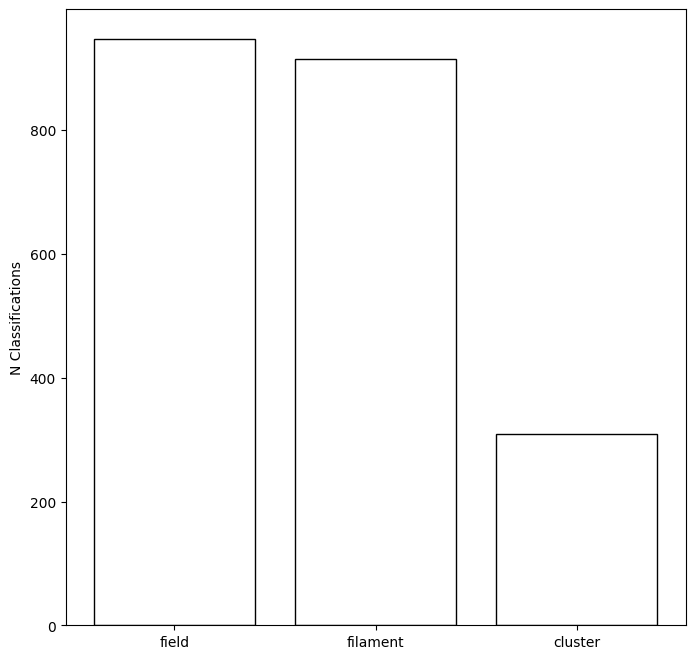

In [58]:
plt.figure(figsize = (8,8))
plt.bar(environment, nums, fill = False)
plt.ylabel('N Classifications')
plt.show()

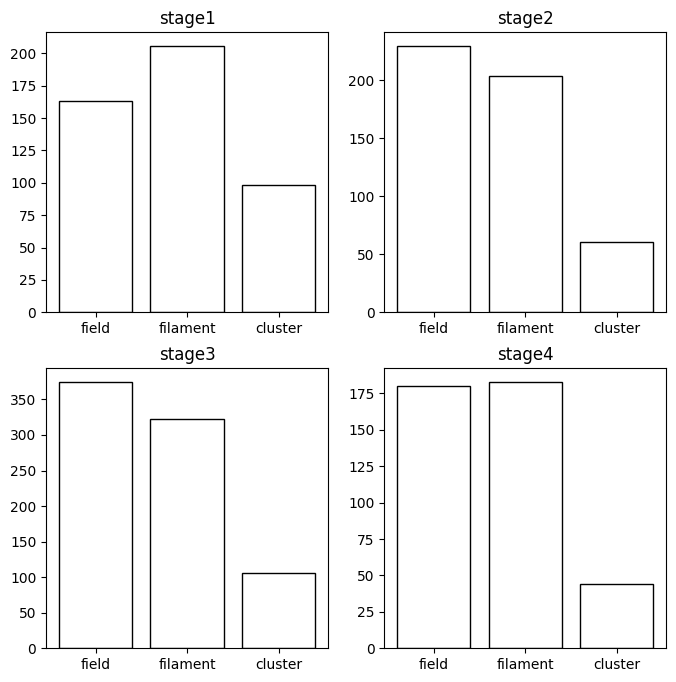

In [59]:
counter = 1
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
for i in range(2):
    for j in range(2):
        stage = f'stage{counter}'
        df_stage = df_environ_merg.query('category == @stage')
        values = [df_stage.environment.value_counts().field, df_stage.environment.value_counts().filament, df_stage.environment.value_counts().cluster]
        
        ax[i,j].bar(environment, values, fill=False)
        ax[i,j].set_title(stage)
        
        counter += 1

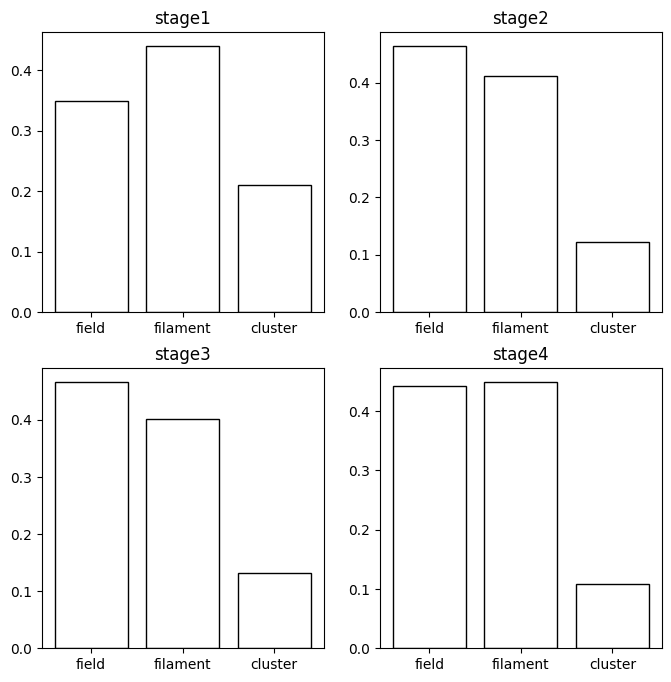

In [60]:
counter = 1
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
for i in range(2):
    for j in range(2):
        stage = f'stage{counter}'
        df_stage = df_environ_merg.query('category == @stage')
        tot_counts = len(df_stage)
        values = [
            df_stage.environment.value_counts().field / tot_counts,
            df_stage.environment.value_counts().filament / tot_counts,
            df_stage.environment.value_counts().cluster / tot_counts
        ]
        
        ax[i,j].bar(environment, values, fill=False)
        ax[i,j].set_title(stage)
        
        counter += 1

### Above Mass-SFR plots with Environment Printed On

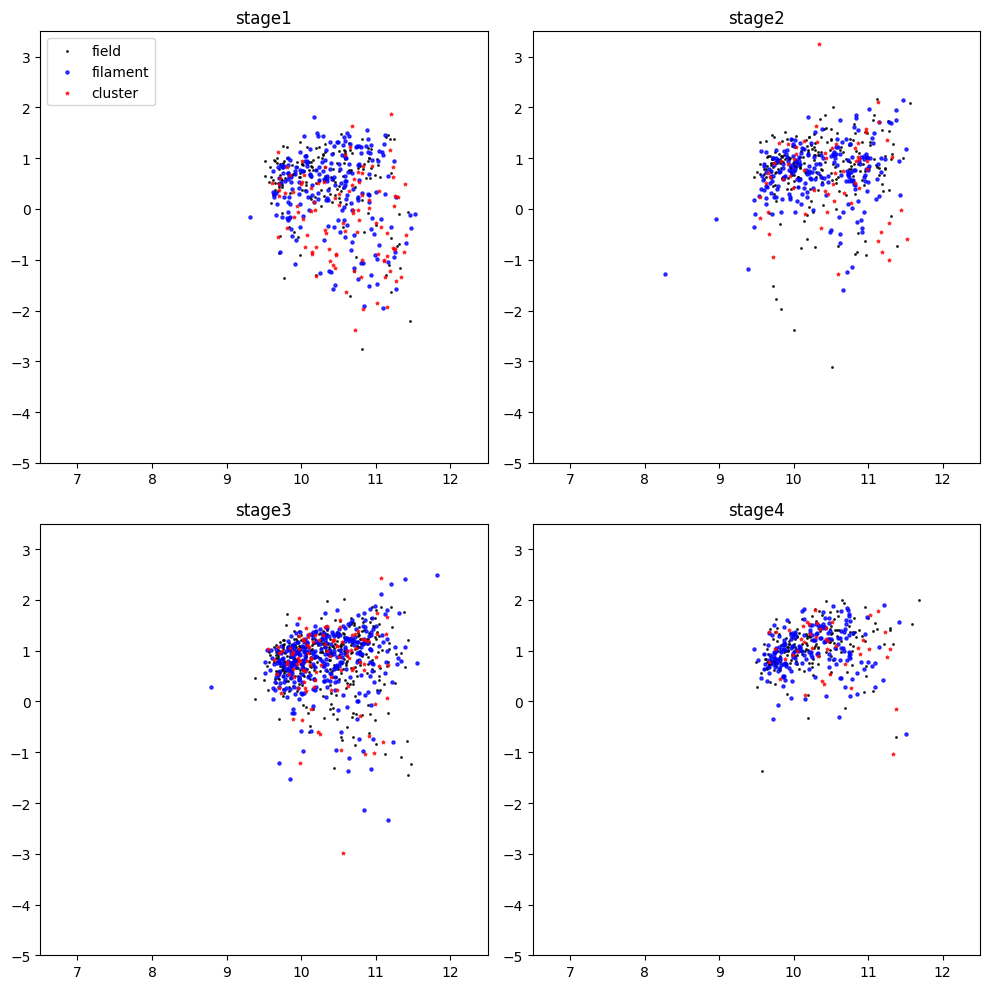

In [29]:
counter = 1
colours = ['black', 'blue', 'red']
markers = ['.', 'o', '*']

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))
for i in range(2):
    for j in range(2):
        stage = f'stage{counter}'
        df_stage = df_environ_merg.query('category == @stage')
        
        for color_count, env in enumerate(environment):
            df_env = df_stage.query('environment == @env')
            ax[i,j].scatter(np.array(df_env.lp_mass_best), np.array(df_env.ez_sfr), color=colours[color_count], marker = markers[color_count], s = 5, alpha = 0.75)
        ax[i,j].set_title(stage)
        ax[i,j].set_xlim([6.5,12.5])
        ax[i,j].set_ylim([-5,3.5])
        
        counter += 1
ax[0,0].legend(environment, loc = 'upper left')
fig.tight_layout()
plt.show()